# Optimal Power Flow Solutions via Linear Optimization

Below are a couple of examples of how to compute the optimal power flow (OPF) of a DC-based power system with inelastic demand using linear optimization.

## Example 1
Suppose we have a network with three generators and three load centers (co-located with generation) with the following parameters and constraints.

Generation Constraints:
* Generator 1: 0-100 MW
* Generator 1 Cost: $50/MWh
* Generator 2: 0-250 MW
* Generator 2 Cost: $70/MWh
* Generator 3: 0-300 MW
* Generator 3: $100/MWh

Demand:
* Demand 1: 0 MW
* Demand 2: 50 MW
* Demand 3: 100 MW

(Max) Flow Constraints F(from node #,to node #):
* F(1,2) = 40 MW
* F(2,3) = 50 MW
* F(3,1) = 50 MW

First, we'll use networkx to create a diagram of the power system we're trying to optimize. 

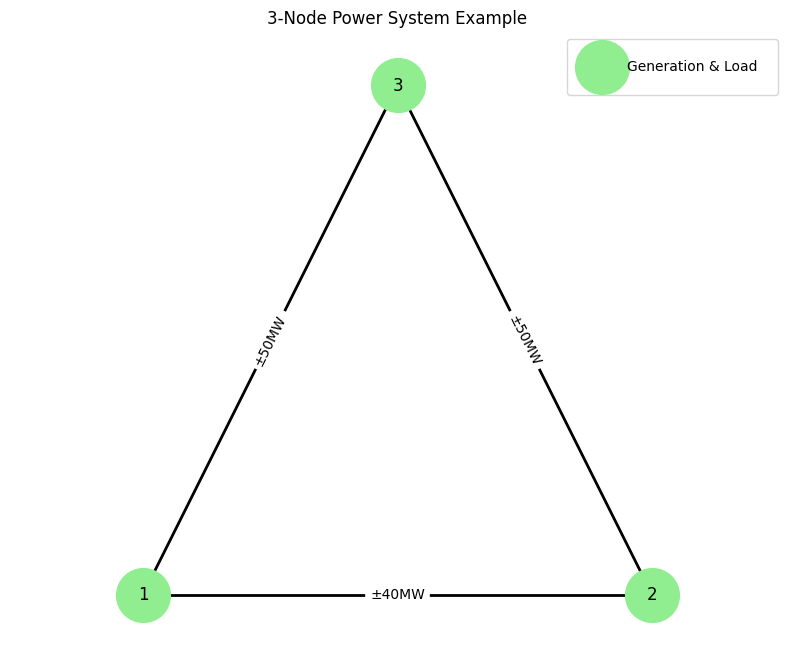

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G = nx.Graph()

# Add nodes
G.add_node(1, pos=(0, 0), node_type='generator and load')
G.add_node(2, pos=(0.5, 0), node_type='generator and load')
G.add_node(3, pos=(0.25, 0.5), node_type='generator and load')

# Add edges
G.add_edge(1, 2, weight=30)  # f12
G.add_edge(2, 3, weight=30)  # f23
G.add_edge(3, 1, weight=30)  # f31


# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Create figure
plt.figure(figsize=(10, 8))

# Draw the network
nx.draw_networkx_edges(G, pos, width=2)

# Draw nodes with different colors based on type
nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'generator and load']

nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='lightgreen', 
                      node_size=1500, label='Generation & Load')

# Add node labels
nx.draw_networkx_labels(G, pos)

# Add edge labels showing flow limits
edge_labels = {(1, 2): '±40MW', (2, 3): '±50MW', (3, 1): '±50MW'}
nx.draw_networkx_edge_labels(G, pos, edge_labels)

# Add legend
plt.legend(labelspacing=3, borderpad=1.5)

# Add title
plt.title('3-Node Power System Example')

# Show grid
plt.axis('equal')
plt.axis('off')
plt.show()

In [2]:
import pulp

# Create the model
model = pulp.LpProblem(name="power_system", sense=pulp.LpMinimize)

# Create variables
# Generation variables with bounds
p1 = pulp.LpVariable('p1', lowBound=0, upBound=100)
p2 = pulp.LpVariable('p2', lowBound=0, upBound=250)
p3 = pulp.LpVariable('p3', lowBound=0, upBound=300)


# Line flow variables with bounds
f12 = pulp.LpVariable('f12', lowBound=-40, upBound=40)
f23 = pulp.LpVariable('f23', lowBound=-50, upBound=50)
f31 = pulp.LpVariable('f34', lowBound=-50, upBound=50)

# Phase angle variables
theta1 = pulp.LpVariable('theta1', lowBound=None, upBound=None, cat='Continuous')
theta2 = pulp.LpVariable('theta2', lowBound=None, upBound=None, cat='Continuous')
theta3 = pulp.LpVariable('theta3', lowBound=None, upBound=None, cat='Continuous')

# Fix theta1 as reference
model += theta1 == 0

# Objective function: minimize generation cost
# Cost coefficients: c1 = 5, c2 = 2, c3 = 3
model += 50*p1 + 70*p2 + 80*p3

# Flow conservation constraints
model += p1 - f12 + f31 == 0, "node1_balance"  # Generator and load at node 1
model += p2 - 20 + f12 - f23 == 0, "node2_balance" # Generator and load at node 2 
model += p3 - 120 + f23 - f31 == 0, "node3_balance"  # Generator and load at node 3

# DC power flow constraints
model += f12 - (theta1 - theta2) == 0, "dc_flow_12"
model += f23 - (theta2 - theta3) == 0, "dc_flow_23"
model += f31 - (theta3 - theta1) == 0, "dc_flow_31"


# Solve the model
model.solve()

print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Optimal cost: {pulp.value(model.objective)}")
print(f"Generation p1: {p1.value()}")
print(f"Generation p2:{p2.value()}")
print(f"Generation p3: {p3.value()}")
print(f"Flows: f12={f12.value()}, f23={f23.value()}, f31={f31.value()}")
print(f"Voltage Angles: theta1:{theta1.value()}, theta2:{theta2.value()}, theta3: {theta3.value()}")

# Try to get dual values if your solver supports it
try:
    for name, constraint in model.constraints.items():
        if "balance" in name:
            print(f"Dual for {name}: {constraint.pi}")
except:
    print("Note: Getting dual values may require specific solver settings")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/robertsmith/PycharmProjects/electricity-optimization/.venv/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/sm/b4sn7nw913j9p3200tll43800000gn/T/6fe365fc780346dab38b6bd124392108-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/sm/b4sn7nw913j9p3200tll43800000gn/T/6fe365fc780346dab38b6bd124392108-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 35 RHS
At line 43 BOUNDS
At line 56 ENDATA
Problem MODEL has 7 rows, 9 columns and 19 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (-4) rows, 5 (-4) columns and 9 (-10) elements
0  Obj 9600 Primal inf 160 (3) Dual inf 79.999999 (1)
4  Obj 8650
Optimal - objective value 8650
After Postsolve, objective 8650, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 8650 - 4 iterations time 0

The optimal cost to supply demand is $8,650. The locational marginal price (LMP) is: 
* Demand at Node 1: $50/MWh
* Demand at Node 2: $65/MWh
* Demand at Node 3: $80/MWh

## Example 2
Suppose we have a network with three generators and three load centers (now separated by transmission) with the following parameters and constraints.

Generation Constraints:
* Generator 1: 10-250 MW
* Generator 1 Cost: $50/MWh
* Generator 2: 10-300 MW
* Generator 2 Cost: $20/MWh
* Generator 3: 10-270 MW
* Generator 3: $30/MWhß

Demand:
* Demand 1: 90 MW
* Demand 2: 100 MW
* Demand 3: 125 MW

(Max) Flow Constraints F(from node #,to node #):
* F(1,2) = 50 MW
* F(2,3) = 60 MW
* F(3,4) = 90 MW
* F(4,5) = 50 MW
* F(5,6) = 120 MW
* F(6,1) = 100 MW

Susceptance Line Parameters B(from node #, to node #):
* B(1,2) = 11.6
* B(2,3) = 5.9
* B(3,4) = 13.7
* B(4,5) = 9.8
* B(5,6) = 5.6
* B(6,1) = 10.5


First, we'll use networkx to visualize the power system we're trying to optimize. 

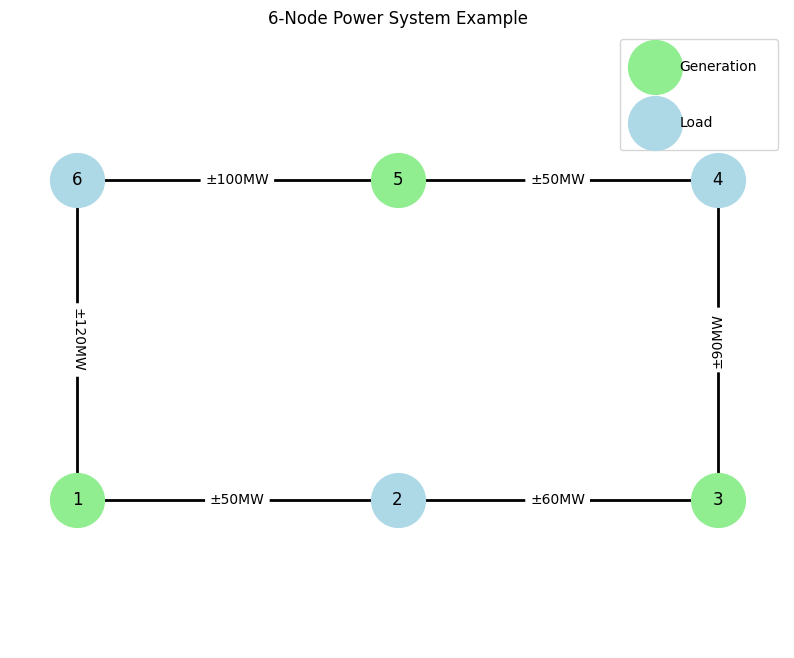

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph
G = nx.Graph()

# Add nodes
G.add_node(1, pos=(0, 0), node_type='generation')
G.add_node(2, pos=(0.5, 0), node_type='load')
G.add_node(3, pos=(1, 0), node_type='generation')
G.add_node(4, pos=(1, 0.5), node_type='load')
G.add_node(5, pos=(0.5, 0.5), node_type='generation')
G.add_node(6, pos=(0, 0.5), node_type='load')

# Add edges
G.add_edge(1, 2, weight=30)  # f12
G.add_edge(2, 3, weight=30)  # f23
G.add_edge(3, 4, weight=30)  # f34
G.add_edge(4, 5, weight=30)  # f45
G.add_edge(5, 6, weight=30)  # f56
G.add_edge(6, 1, weight=30)  # f61


# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Create figure
plt.figure(figsize=(10, 8))

# Draw the network
nx.draw_networkx_edges(G, pos, width=2)

# Draw nodes with different colors based on type
generator_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'generation']
load_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'load']

nx.draw_networkx_nodes(G, pos, nodelist=generator_nodes, node_color='lightgreen', 
                      node_size=1500, label='Generation')
nx.draw_networkx_nodes(G, pos, nodelist=load_nodes, node_color='lightblue',
                      node_size=1500, label='Load')

# Add node labels
nx.draw_networkx_labels(G, pos)

# Add edge labels showing flow limits
edge_labels = {(1, 2): '±50MW', (2, 3): '±60MW', (3, 4): '±90MW', (4,5):'±50MW',(5,6): '±100MW', (6,1): '±120MW'}
nx.draw_networkx_edge_labels(G, pos, edge_labels)

# Add legend
plt.legend(labelspacing=3, borderpad=1.5)

# Add title
plt.title('6-Node Power System Example')

# Show grid
plt.axis('equal')
plt.axis('off')
plt.show()

Now, let's use pulp to solve via linear optimization!

In [4]:
import pulp

# Create the model
model = pulp.LpProblem(name="power_system", sense=pulp.LpMinimize)

# Create variables
# Generation variables with bounds
p1 = pulp.LpVariable('p1', lowBound=10, upBound=250)
p2 = pulp.LpVariable('p2', lowBound=10, upBound=300)
p3 = pulp.LpVariable('p3', lowBound=10, upBound=270)


# Line flow variables with bounds
f12 = pulp.LpVariable('f12', lowBound=-50, upBound=50)
f23 = pulp.LpVariable('f23', lowBound=-60, upBound=60)
f34 = pulp.LpVariable('f34', lowBound=-90, upBound=90)
f45 = pulp.LpVariable('f45', lowBound=-50, upBound=50)
f56 = pulp.LpVariable('f56', lowBound=-120, upBound=120)
f61 = pulp.LpVariable('f61', lowBound=-100, upBound=100)

# Phase angle variables
theta1 = pulp.LpVariable('theta1', lowBound=None, upBound=None, cat='Continuous')
theta2 = pulp.LpVariable('theta2', lowBound=None, upBound=None, cat='Continuous')
theta3 = pulp.LpVariable('theta3', lowBound=None, upBound=None, cat='Continuous')
theta4 = pulp.LpVariable('theta4', lowBound=None, upBound=None, cat='Continuous')
theta5 = pulp.LpVariable('theta5', lowBound=None, upBound=None, cat='Continuous')
theta6 = pulp.LpVariable('theta6', lowBound=None, upBound=None, cat='Continuous')

# Fix theta1 as reference
model += theta1 == 0

# Objective function: minimize generation cost
# Cost coefficients: c1 = 5, c2 = 2, c3 = 3
model += 50*p1 + 20*p2 + 30*p3

# Flow conservation constraints
model += p1 - f12 + f61 == 0, "node1_balance"  # Generator node 1
model += -90 + f12 - f23 == 0, "node2_balance" # Load node 2 
model += p2 - f34 + f23 == 0, "node3_balance"  # Generator node 3
model += -100 + f34 - f45 == 0, "node4_balance"  # Load node 4
model += p3 - f56 + f45 == 0, "node5_balance"  # Generator node 5
model += -125 + f56 - f61 ==0 , "node6_balance" # Load node 6

# DC power flow constraints
model += f12 - 11.6*(theta1 - theta2) == 0, "dc_flow_12"
model += f23 - 5.9*(theta2 - theta3) == 0, "dc_flow_23"
model += f34 - 13.7*(theta3 - theta4) == 0, "dc_flow_34"
model += f45 - 9.8*(theta4 - theta5) == 0, "dc_flow_45"
model += f56 - 5.6*(theta5 - theta6) == 0, "dc_flow_56"
model += f61 - 10.5*(theta6 - theta1) == 0, "dc_flow_61"

# Solve the model
model.solve()

print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Optimal cost: {pulp.value(model.objective)}")
print(f"Generation p1: {p1.value()}")
print(f"Generation p2:{p2.value()}")
print(f"Generation p3: {p3.value()}")
print(f"Flows: f12={f12.value()}, f23={f23.value()}, f34={f34.value()}, f45={f45.value()}, f56={f56.value()}, f61={f61.value()}")
print(f"Voltage Angles: theta1:{theta1.value()}, theta2:{theta2.value()}, theta3: {theta3.value()}, theta4:{theta4.value()}, theta5:{theta5.value()}, theta6: {theta6.value()}")

# Try to get dual values if your solver supports it
try:
    for name, constraint in model.constraints.items():
        if "balance" in name:
            print(f"Dual for {name}: {constraint.pi}")
except:
    print("Note: Getting dual values may require specific solver settings")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/robertsmith/PycharmProjects/electricity-optimization/.venv/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/sm/b4sn7nw913j9p3200tll43800000gn/T/ca2ed82cf33848238d69a373ec8282ea-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/sm/b4sn7nw913j9p3200tll43800000gn/T/ca2ed82cf33848238d69a373ec8282ea-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 18 COLUMNS
At line 56 RHS
At line 70 BOUNDS
At line 95 ENDATA
Problem MODEL has 13 rows, 15 columns and 34 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-13) rows, 0 (-15) columns and 0 (-34) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 9920.4365
After Postsolve, objective 9920.4365, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 9920.436527 - 0 iterations ti

The optimal cost to supply demand is $9,920. The locational marginal price (LMP) is: 
* Demand 1 at Node 2: $56.30/MWh
* Demand 2 at Node 4: $25.34/MWh
* Demand 3 at Node 6: $43.05/MWh